# Explore NDVI Predictions for ESA AI Conference

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

# Read in the data

In [4]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

In [5]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

In [6]:
bline_pred = read_pred_data('previous_month', data_dir)[-1].where(~mask)
lr_pred = read_pred_data('linear_regression', data_dir)[-1].where(~mask)
ln_pred = read_pred_data('linear_network', data_dir)[-1].where(~mask)
rnn_pred = read_pred_data('rnn', data_dir)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir)[-1].where(~mask)
# ealstm_pred = read_pred_data('ealstm', data_dir)

# explore train/test split

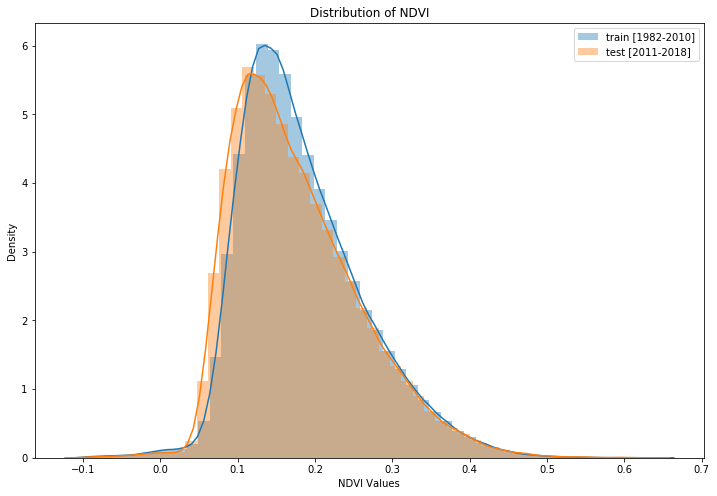

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_train.ndvi), ax=ax, label='train [1982-2010]')
sns.distplot(drop_nans_and_flatten(y_test.ndvi), ax=ax, label='test [2011-2018]')
plt.legend()
ax.set_ylabel('Density')
ax.set_xlabel('NDVI Values')
ax.set_title('Distribution of NDVI');

What does the NDVI look like in the train years vs. the test years?

Text(0.5, 1.0, 'Mean Annual NDVI')

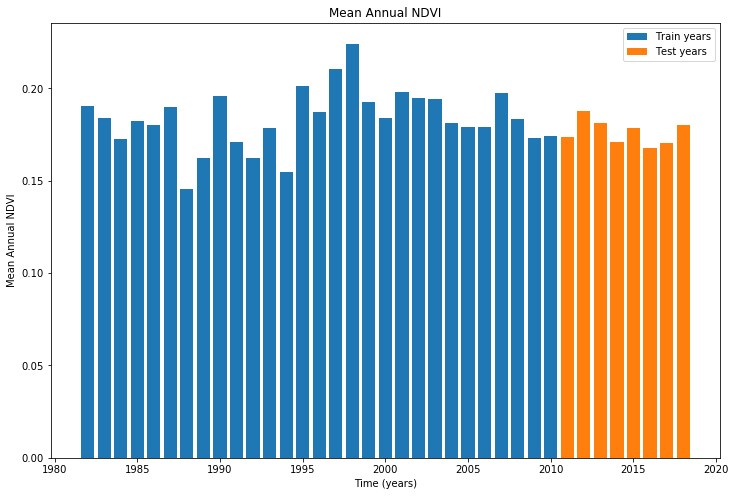

In [77]:
annual_vals = y_train.groupby('time.year').mean(dim=['time', 'lat', 'lon']).ndvi.values
years = np.unique(y_train['time.year'].values)

annual_vals_test = y_test.groupby('time.year').mean(dim=['time', 'lat', 'lon']).ndvi.values
years_test = np.unique(y_test['time.year'].values)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(height=annual_vals, x=years, label='Train years')
ax.bar(height=annual_vals_test, x=years_test, label='Test years')

plt.legend()
plt.title('Mean Annual NDVI')
ax.set_ylabel('Mean Annual NDVI')
ax.set_xlabel('Time (years)');
ax.set_title('Mean Annual NDVI')

April, May, June (the peak NDVI months - see seasonality below) have a slightly different pattern

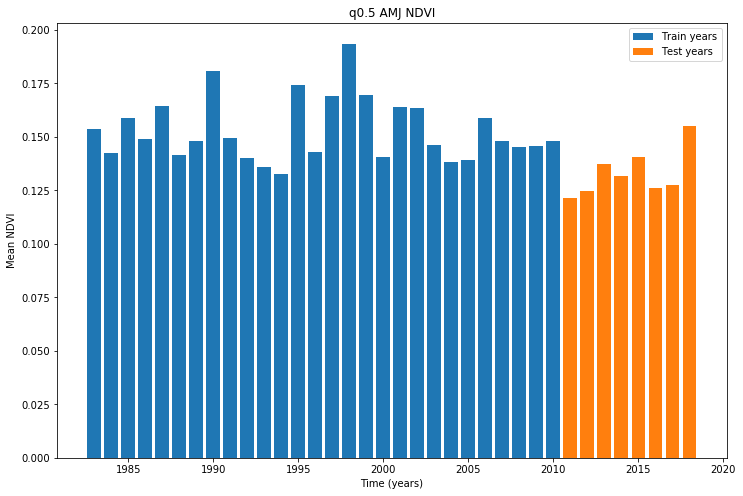

In [78]:
q = 0.5

def is_amj(month):
    return (month >= 4) & (month <= 6)


def is_NDJ(month):
    return (month == 12) | (month == 1) | (month == 2)


annual_vals = (
    y_train.sel(time=is_amj(y_train['time.month']))
    .groupby('time.year')
    .reduce(np.nanpercentile, dim='time', q=q)
    .mean(dim=['lat', 'lon'])
    .ndvi
)
years = annual_vals.year.values

annual_vals_test = (
    y_test.sel(time=is_amj(y_test['time.month']))
    .groupby('time.year')
    .reduce(np.nanpercentile, dim='time', q=q)
    .mean(dim=['lat', 'lon'])
    .ndvi
)
years_test = annual_vals_test.year.values

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(height=annual_vals.values, x=years, label='Train years')
ax.bar(height=annual_vals_test.values, x=years_test, label='Test years')

plt.legend()
plt.title(f'q{q} AMJ NDVI')
ax.set_ylabel('Mean NDVI')
ax.set_xlabel('Time (years)');

# Explore Climatology / Seasonality

In [6]:
from src.analysis import PercentNormalIndex
from src.utils import create_shape_aligned_climatology
import calendar

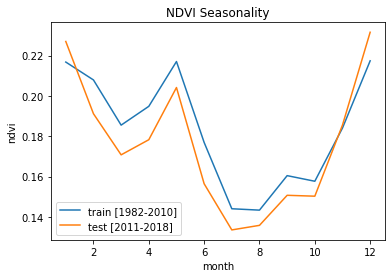

In [110]:
fig, ax = plt.subplots(figsize=(12, 8))
# xr.merge([y_train, y_test]).groupby('time.month').mean().ndvi.plot(ax=ax)
y_train.groupby('time.month').mean().ndvi.plot(ax=ax, label='train [1982-2010]')
y_test.groupby('time.month').mean().ndvi.plot(ax=ax, label='test [2011-2018]')
ax.set_title('NDVI Seasonality');
plt.legend();

In [7]:
def calculate_climatology(ds: xr.Dataset, 
                          variable: str, 
                          time_period: str = 'month') -> xr.Dataset:
    # calculate climatology based on time_period
    mthly_climatology = (
        ds
        .groupby(f'time.{time_period}')
        .mean(dim='time')
    )
    clim = create_shape_aligned_climatology(
        ds, mthly_climatology, variable, time_period
    )
    
    return clim


clim = calculate_climatology(y_train, variable='ndvi')

In [8]:
def plot_annual_ndvi_maps(month_ds: xr.Dataset, 
                          variable: str, 
                          time_str: str = 'time',
                          **kwargs) -> None:
    fig, axs = plt.subplots(3, 4, figsize=(12, 8))
    for i in range(0, 12):
        da = month_ds.isel({time_str: i})[variable]
        ax_ix = np.unravel_index(i, (3, 4))
        ax = axs[ax_ix]
        da.plot(ax=ax, **kwargs)

        ax.set_title(calendar.month_abbr[i+1])
        ax.set_axis_off()
        
    return fig, ax

## Spatial NDVI patterns

In [59]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

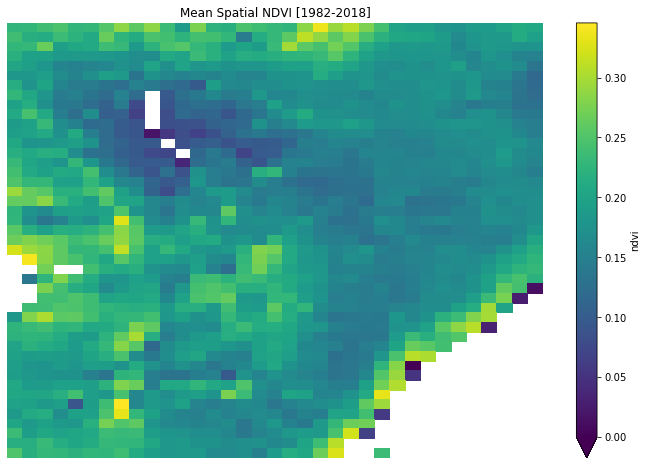

In [67]:
ds = xr.merge([y_train, y_test]).sortby('time')
fig, ax = plt.subplots(figsize=(12, 8))

ds.where(~mask).mean(dim='time').ndvi.plot(ax=ax, vmin=0)
ax.set_axis_off();
ax.set_title('Mean Spatial NDVI [1982-2018]');

In [ ]:
# data_dir / 'interim' / 'NDVI_preprocessed'

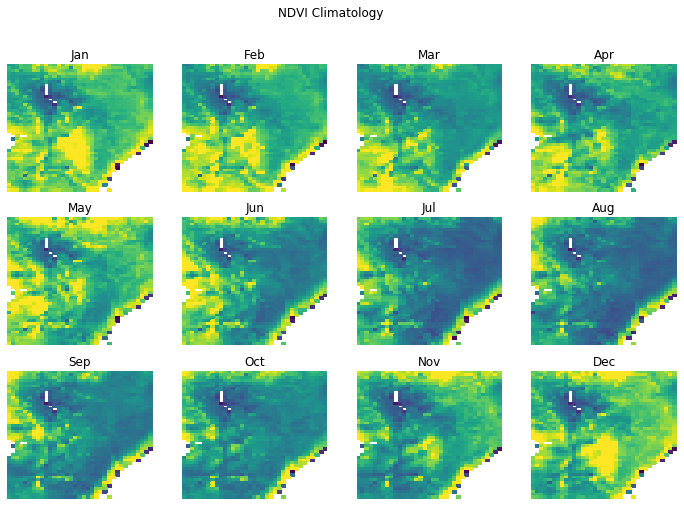

In [68]:
# plot climatology
mths = clim.sel(time='1991').where(~mask)
fig, ax = plot_annual_ndvi_maps(
    mths, variable='ndvi',
    **dict(add_colorbar=False, vmax=0.3, vmin=0)
)

fig.suptitle('NDVI Climatology');

In [69]:
# create y_test shaped array of climatology
test_clim = xr.ones_like(y_test).where(~mask)
test_clim['ndvi'] = (('time', 'lat', 'lon'), np.repeat(mths.ndvi.values, 8, axis=0))

# create y_test anomalies
y_test_anomaly = y_test - test_clim
y_test_anomaly

# create y_train anomalies
y_train_anomaly = y_train - clim
y_train_anomaly

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 341)
Coordinates:
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 1982-08-31 1982-09-30 ... 2010-12-31
Data variables:
    ndvi     (time, lat, lon) float64 -0.0119 -0.07226 -0.01303 ... nan nan nan

Now that we have calculated the climatology, we can use it to check whether our test period is anomalous. 

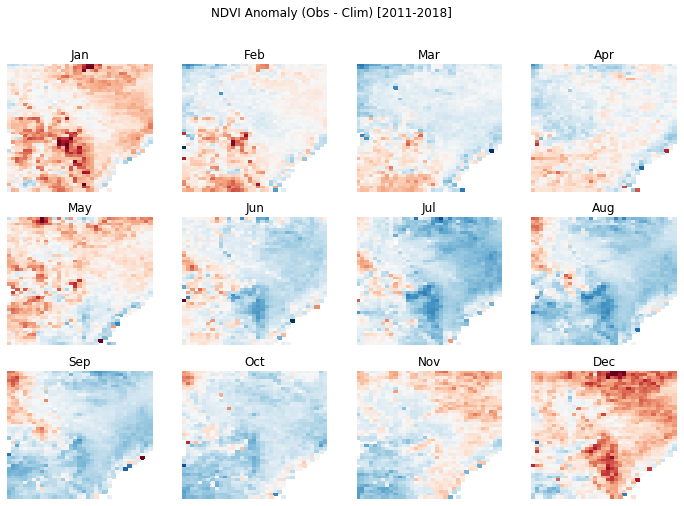

In [341]:
fig, ax = plot_annual_ndvi_maps(
    (
        y_test_anomaly
        .groupby('time.month')
        .mean(dim=['time'])
        .sel()
    ), time_str='month', variable='ndvi',
    **dict(add_colorbar=False, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
)

fig.suptitle('NDVI Anomaly (Obs - Clim) [2011-2018]');

# Explore the test data

In [9]:
def plot_ndvi_anomaly_year(year: str):
    fig, ax = plot_annual_ndvi_maps(
        month_ds=y_test_anomaly.sel(time=year), 
        time_str='time', variable='ndvi',
        **dict(add_colorbar=False, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
    )

    fig.suptitle(f'NDVI Anomaly (Obs - Clim) [{year}]');

In [547]:
plot_ndvi_anomaly_year(year='2011')

In [548]:
plot_ndvi_anomaly_year(year='2016')

# Explore Predictions

In [192]:
import calendar

obs = y_test.ndvi
pred = ealstm_pred
spatial_plot_kwargs = dict(cmap='viridis', vmin=0, vmax=0.4)


def _plot_single_month_(obs_mth: xr.DataArray, pred_mth: xr.DataArray, month: int) -> None:
    flat_obs = drop_nans_and_flatten(obs_mth)
    flat_pred = drop_nans_and_flatten(pred_mth)

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.distplot(flat_obs, ax=ax, label='Observed')
    sns.distplot(flat_pred, ax=ax, label='Predicted')
    plt.legend();
    ax.get_yaxis().set_visible(False)
    ax.set_title(calendar.month_abbr[month + 1])
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    obs_mth.plot(ax=axs[0], add_colorbar=False, **spatial_plot_kwargs)
    axs[0].set_title('Observed')
    axs[0].set_axis_off()
    pred_mth.plot(ax=axs[1], add_colorbar=False, **spatial_plot_kwargs)
    axs[1].set_title('Predicted')
    axs[1].set_axis_off()
    plt.show()


# def plot_model_performances(month: int, 
#                             obs: xr.DataArray, 
#                             pred: xr.DataArray,
#                             **spatial_plot_kwargs) -> None:
#          obs_mth = obs.groupby(obs.time.dt.month).mean(dim='time').isel(month=month)
#          pred_mth = pred.groupby(pred.time.dt.month).mean(dim='time').isel(month=month)
#         _plot_single_month_(obs_mth, pred_mth)

def plot_year_month_performances(year: int):
    for month in range(0, 12):
        assert (month < 12 ) & (month >= 0), 'Expect month == 0-11'
        assert obs.shape == pred.shape, 'Expect the obs and pred to have the same shape' \
            f'obs: {obs.shape} / pred: {pred.shape}'

        obs_mth = obs.sel(time=str(year)).isel(time=month)
        pred_mth = pred.sel(time=str(year)).isel(time=month)
        _plot_single_month_(obs_mth, pred_mth, month)

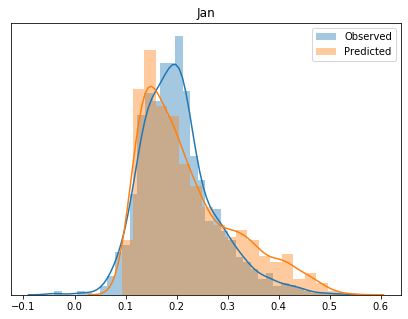

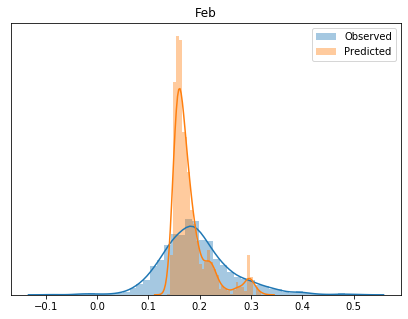

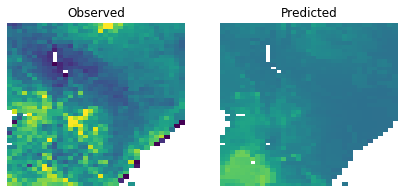

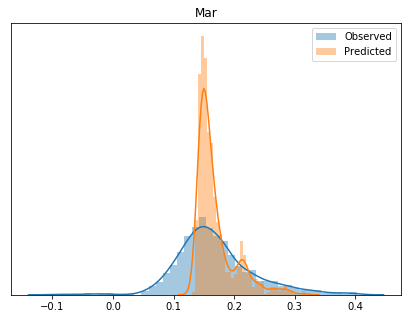

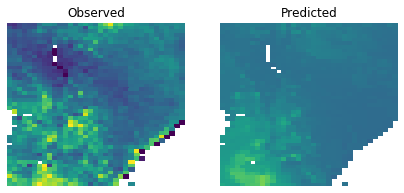

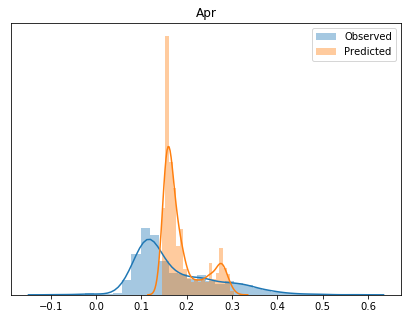

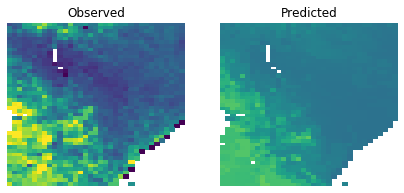

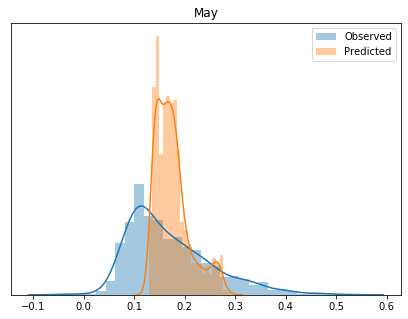

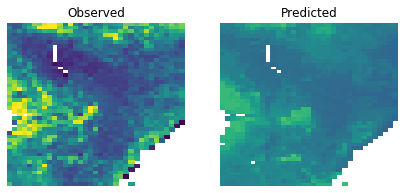

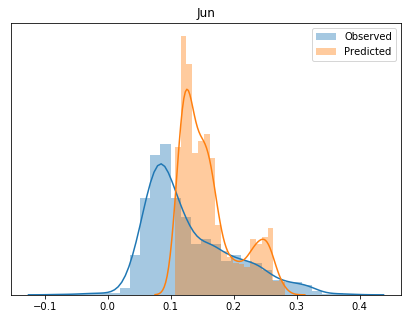

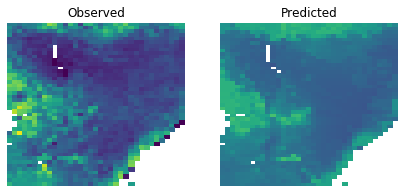

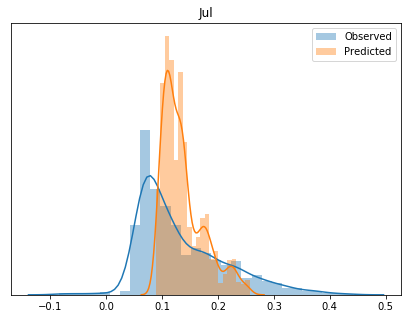

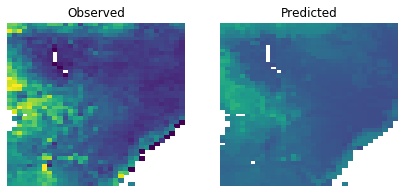

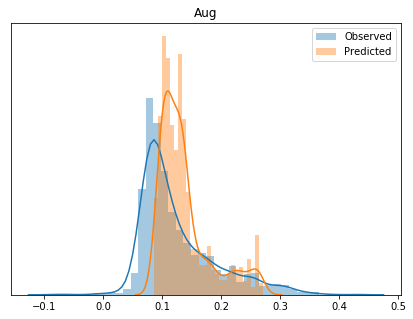

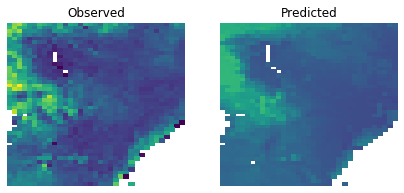

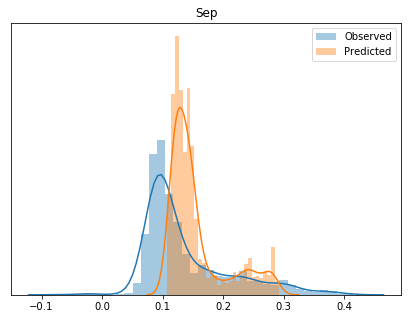

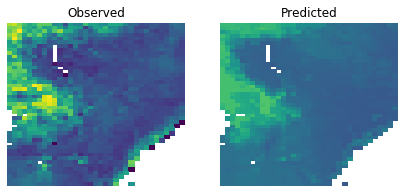

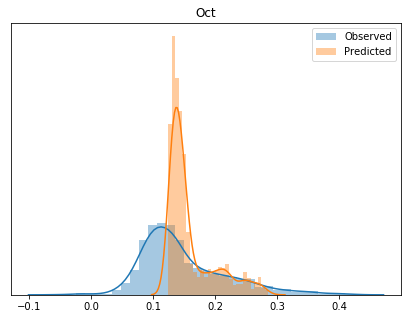

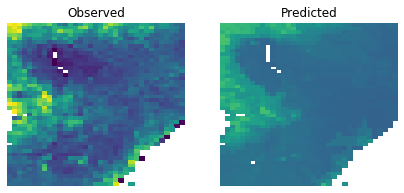

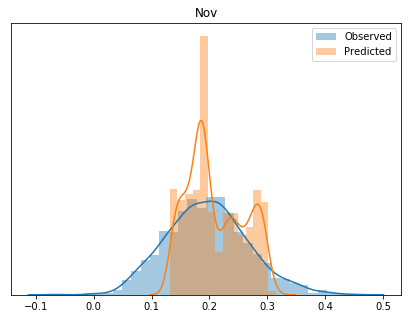

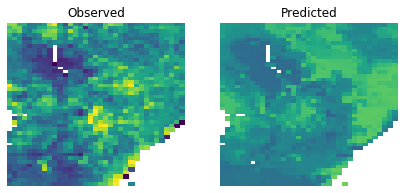

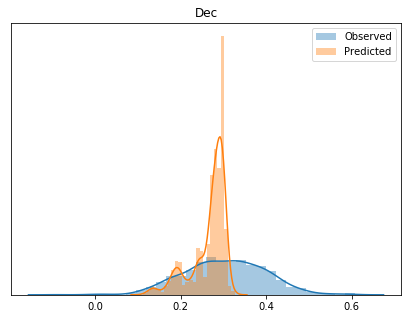

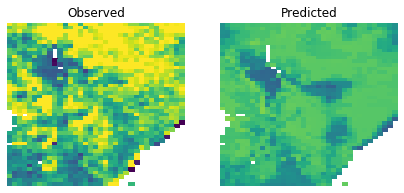

In [193]:
plot_year_month_performances(2011)

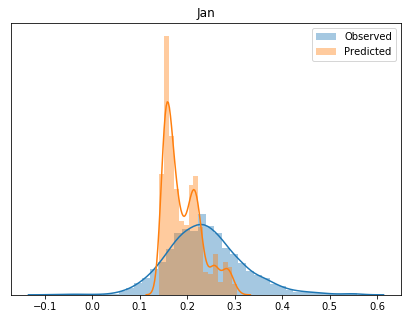

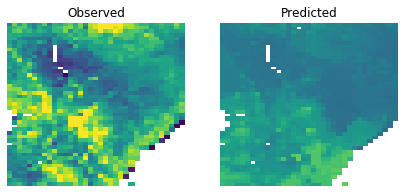

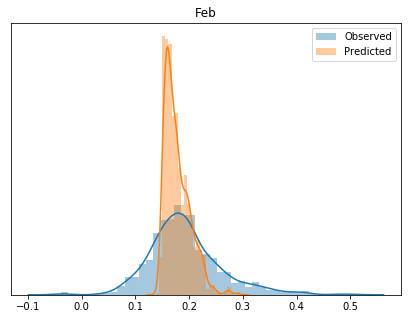

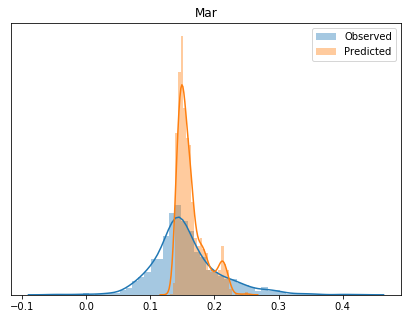

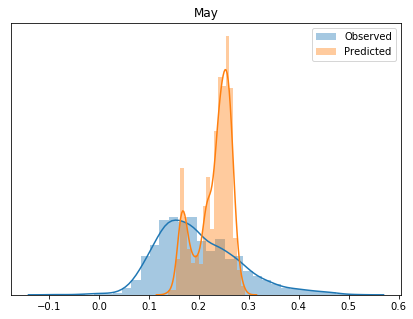

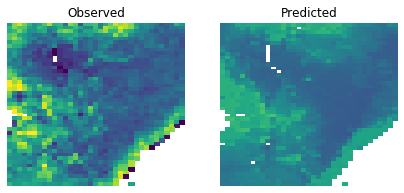

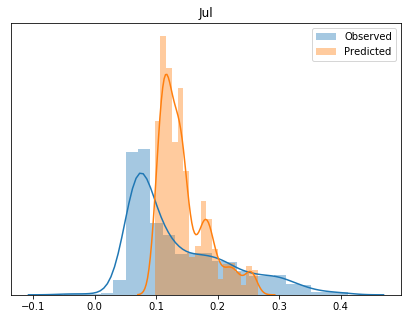

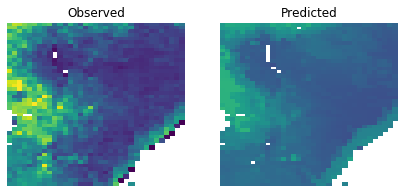

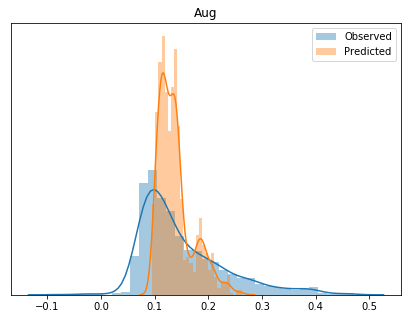

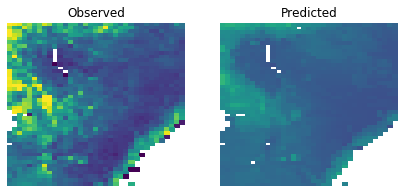

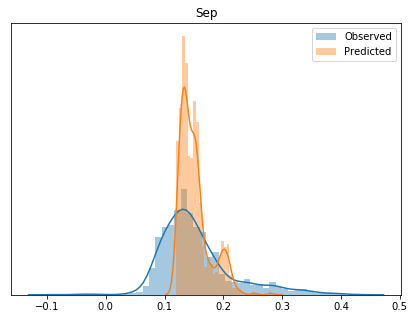

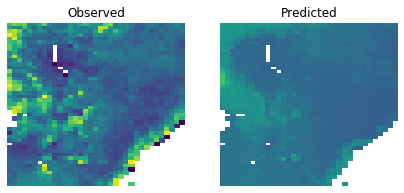

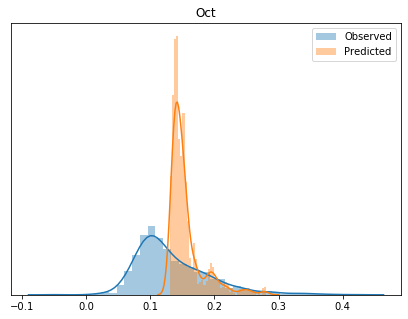

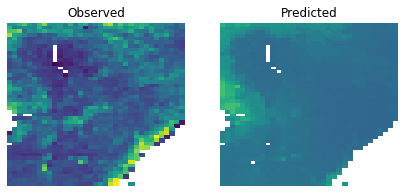

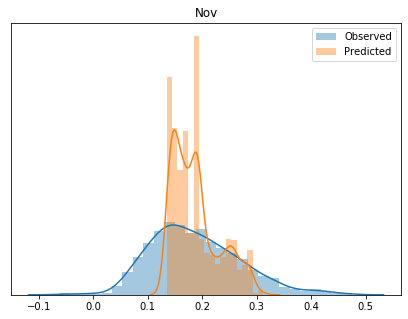

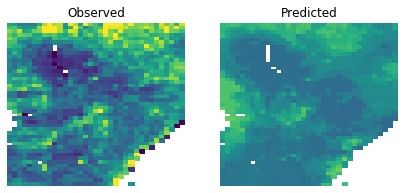

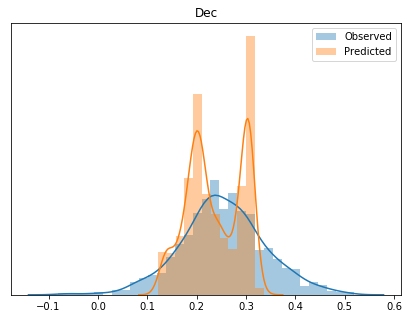

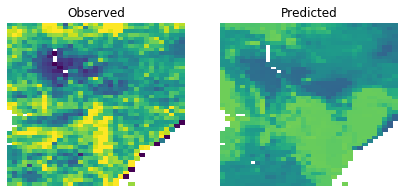

In [194]:
plot_year_month_performances(2015)


# Model performance

- Look at the performance in each month - how do we perform vs. the baseline?
- Looks like none of the models do better than the baseline

In [10]:
from src.analysis import annual_scores

In [11]:
# load the monthly scores dictionary
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['previous_month', 'rnn', 'linear_regression', 'linear_network', 'ealstm'],
    metrics=['rmse', 'r2'],
    target_var='ndvi',
    verbose=False,
    to_dataframe=True
)

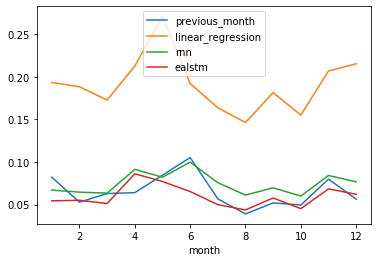

In [352]:
fig, ax = plt.subplots()
for model in ['previous_month', 'linear_regression', 'rnn', 'ealstm']: # 'linear_network',
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()

# Models vs. Observations

- The linear regression scale is off, perhaps the very low learning rate is leading to the values to be shrunk towards 0
- but the spatial patterns are kind of sensible which is handy

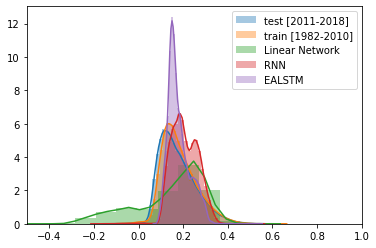

In [368]:
fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(y_test.ndvi), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.ndvi), ax=ax, label='train [1982-2010]')
# sns.distplot(drop_nans_and_flatten(bline_pred), ax=ax, label='Baseline (persistence)')
# sns.distplot(drop_nans_and_flatten(lr_pred), ax=ax, label='Linear Regression')
sns.distplot(drop_nans_and_flatten(ln_pred), ax=ax, label='Linear Network')
sns.distplot(drop_nans_and_flatten(rnn_pred), ax=ax, label='RNN')
sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='EALSTM')

ax.set_xlim([-0.5, 1])
plt.legend()

### Why is linear regression so weird?

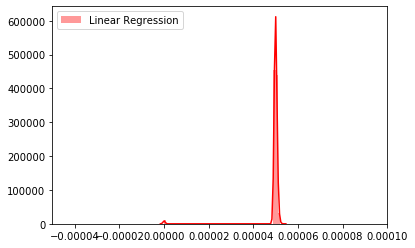

In [154]:
fig, ax = plt.subplots()
# sns.distplot(drop_nans_and_flatten(y_test.ndvi), ax=ax, label='test [2011-2018]')
sns.distplot(drop_nans_and_flatten(lr_pred), ax=ax, label='Linear Regression', color='r')

ax.set_xlim([-0.00005, 0.0001])
plt.legend()

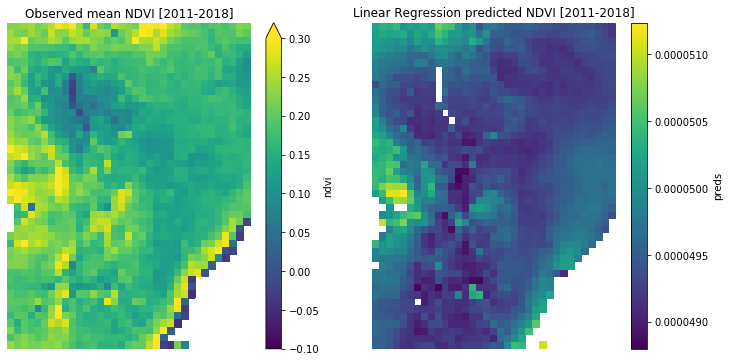

In [177]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
y_test.mean(dim='time').ndvi.plot(ax=axs[0], cmap='viridis', vmin=-0.1, vmax=0.3)
lr_pred.mean(dim='time').plot(ax=axs[1])

axs[0].set_title('Observed mean NDVI [2011-2018]')
axs[0].set_axis_off()
axs[1].set_title('Linear Regression predicted NDVI [2011-2018]')
axs[1].set_axis_off()

## How do the other models perform?

### Linear Network

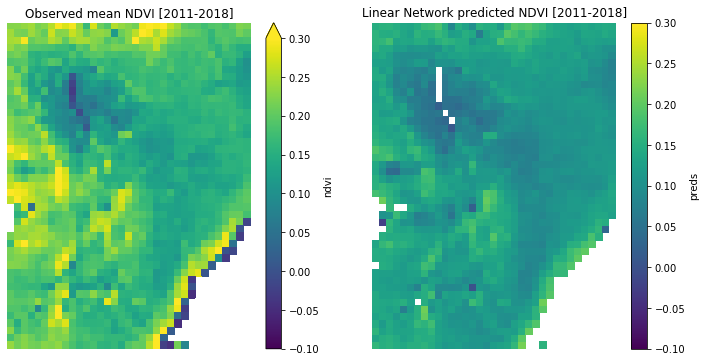

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
y_test.mean(dim='time').ndvi.plot(ax=axs[0], cmap='viridis', vmin=-0.1, vmax=0.3)
ln_pred.mean(dim='time').plot(ax=axs[1], vmin=-0.1, vmax=0.3)

axs[0].set_title('Observed mean NDVI [2011-2018]')
axs[0].set_axis_off()
axs[1].set_title('Linear Network predicted NDVI [2011-2018]')
axs[1].set_axis_off()

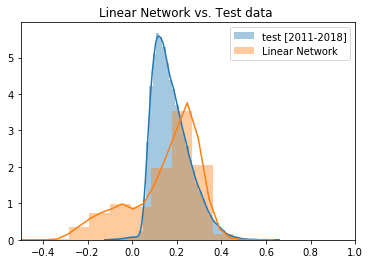

In [182]:
fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(y_test.ndvi), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.ndvi), ax=ax, label='train [1982-2010]')
sns.distplot(drop_nans_and_flatten(ln_pred), ax=ax, label='Linear Network')
# sns.distplot(drop_nans_and_flatten(rnn_pred), ax=ax, label='RNN')
ax.set_title('Linear Network vs. Test data ')
ax.set_xlim([-0.5, 1])
plt.legend()

### LSTM

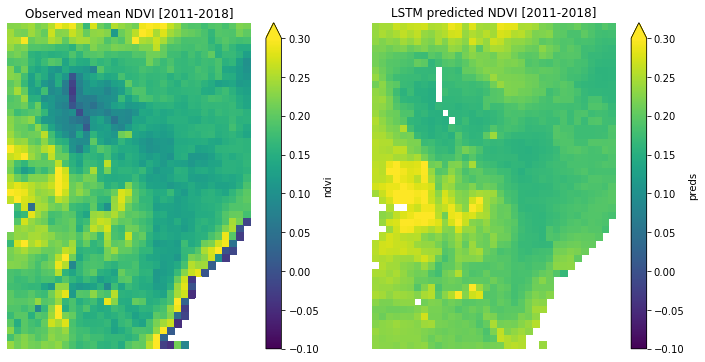

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
y_test.mean(dim='time').ndvi.plot(ax=axs[0], cmap='viridis', vmin=-0.1, vmax=0.3)
rnn_pred.mean(dim='time').plot(ax=axs[1], vmin=-0.1, vmax=0.3)

axs[0].set_title('Observed mean NDVI [2011-2018]')
axs[0].set_axis_off()
axs[1].set_title('LSTM predicted NDVI [2011-2018]')
axs[1].set_axis_off()

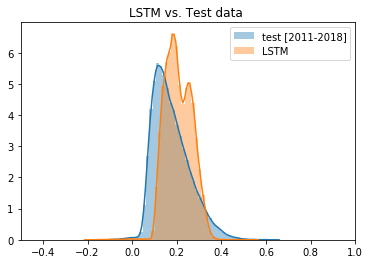

In [181]:
fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(y_test.ndvi), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.ndvi), ax=ax, label='train [1982-2010]')
# sns.distplot(drop_nans_and_flatten(ln_pred), ax=ax, label='Linear Network')
sns.distplot(drop_nans_and_flatten(rnn_pred), ax=ax, label='LSTM')
ax.set_title('LSTM vs. Test data ')
ax.set_xlim([-0.5, 1])
plt.legend()

### EALSTM

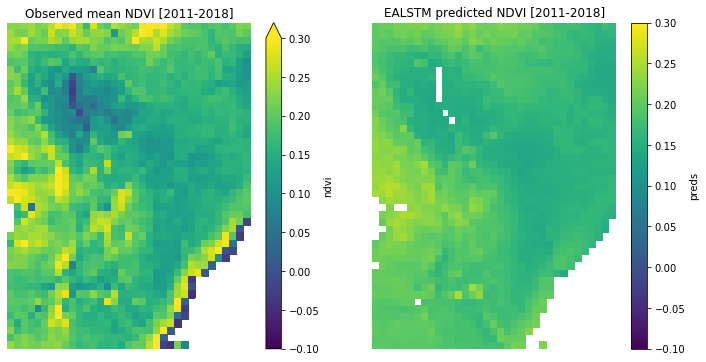

In [366]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
y_test.mean(dim='time').ndvi.plot(ax=axs[0], cmap='viridis', vmin=-0.1, vmax=0.3)
ealstm_pred.mean(dim='time').plot(ax=axs[1], vmin=-0.1, vmax=0.3)

axs[0].set_title('Observed mean NDVI [2011-2018]')
axs[0].set_axis_off()
axs[1].set_title('EALSTM predicted NDVI [2011-2018]')
axs[1].set_axis_off()

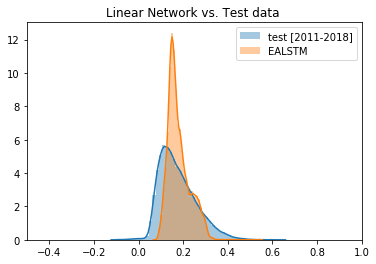

In [370]:
fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(y_test.ndvi), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.ndvi), ax=ax, label='train [1982-2010]')
# sns.distplot(drop_nans_and_flatten(ln_pred), ax=ax, label='Linear Network')
sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='EALSTM')
ax.set_title('Linear Network vs. Test data ')
ax.set_xlim([-0.5, 1])
plt.legend()

### Compare all 3

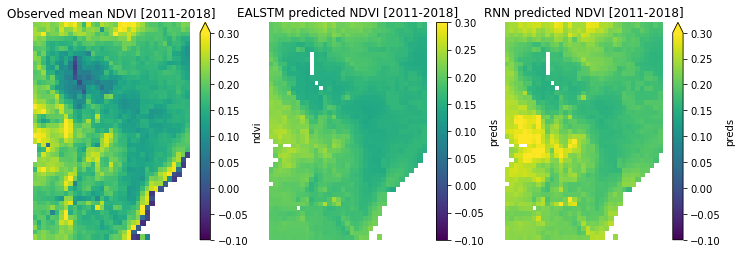

In [500]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
y_test.mean(dim='time').ndvi.plot(ax=axs[0], cmap='viridis', vmin=-0.1, vmax=0.3)
ealstm_pred.mean(dim='time').plot(ax=axs[1], vmin=-0.1, vmax=0.3)
rnn_pred.mean(dim='time').plot(ax=axs[2], vmin=-0.1, vmax=0.3)

axs[0].set_title('Observed mean NDVI [2011-2018]')
axs[0].set_axis_off()
axs[1].set_title('EALSTM predicted NDVI [2011-2018]')
axs[1].set_axis_off()
axs[2].set_title('RNN predicted NDVI [2011-2018]')
axs[2].set_axis_off()

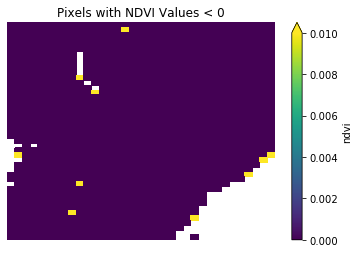

In [537]:
from src.utils import get_ds_mask

mask = get_ds_mask(y_test.ndvi)
fig, ax = plt.subplots()
(y_test.ndvi < 0).astype('int').where(~mask).mean(dim='time').plot(vmax=0.01, ax=ax)
ax.set_title('Pixels with NDVI Values < 0');
ax.set_axis_off()

### For specific timesteps (not mean conditions)

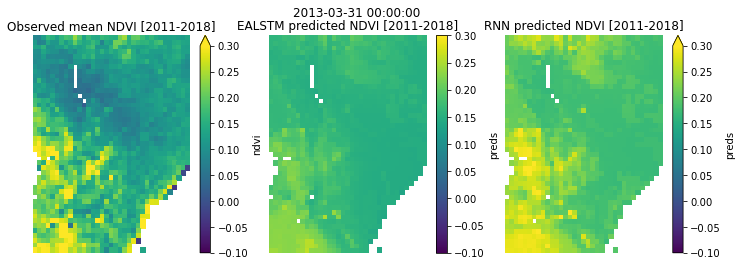

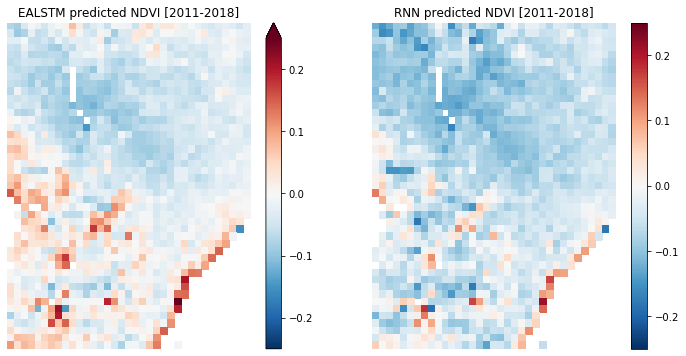

In [521]:
i_time = 26

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
y_test.isel(time=i_time).ndvi.plot(ax=axs[0], cmap='viridis', vmin=-0.1, vmax=0.3)
ealstm_pred.isel(time=i_time).plot(ax=axs[1], vmin=-0.1, vmax=0.3)
rnn_pred.isel(time=i_time).plot(ax=axs[2], vmin=-0.1, vmax=0.3)

axs[0].set_title('Observed mean NDVI [2011-2018]')
axs[0].set_axis_off()
axs[1].set_title('EALSTM predicted NDVI [2011-2018]')
axs[1].set_axis_off()
axs[2].set_title('RNN predicted NDVI [2011-2018]')
axs[2].set_axis_off()

fig.suptitle(pd.to_datetime(y_test.isel(time=i_time).time.values));

# y_test.isel(time=i_time).ndvi - ealstm_pred.isel(time=i_time)
# rnn_pred.isel(time=i_time)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

(y_test.isel(time=i_time).ndvi - ealstm_pred.isel(time=i_time)).plot(ax=axs[0], vmin=-0.25, vmax=0.25, cmap='RdBu_r')
(y_test.isel(time=i_time).ndvi - rnn_pred.isel(time=i_time)).plot(ax=axs[1], vmin=-0.25, vmax=0.25, cmap='RdBu_r')

axs[0].set_axis_off()
axs[0].set_title('EALSTM predicted NDVI [2011-2018]')

axs[1].set_axis_off()
axs[1].set_title('RNN predicted NDVI [2011-2018]');

In [372]:
# y_test.isel(time=i_time).ndvi - ealstm_pred.isel(time=i_time)

def plot_comparison(obs_da: xr.DataArray, pred_da: xr.DataArray, **kwargs):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    obs_da.plot(ax=axs[0], **kwargs)
    pred_da.mean(dim='time').plot(ax=axs[1], **kwargs)

    axs[0].set_title('Observed')
    axs[0].set_axis_off()
    axs[1].set_title('Predicted')
    axs[1].set_axis_off()
    
    
def plot_difference(obs_da: xr.Dataset, pred_da: xr.Dataset, ax, **kwargs):
    (obs_da - pred_da).plot(ax=ax, **kwargs)
    ax.set_axis_off()
    

def time_step_difference(obs_da: xr.Dataset, pred_da: xr.Dataset, variable: str, ax):
    plot_difference(obs_da, pred_da)


(y_test.isel(time=i_time).ndvi - ealstm_pred.isel(time=i_time)).plot(ax=axs[0], vmin=-0.25, vmax=0.25, cmap='RdBu_r')
(y_test.isel(time=i_time).ndvi - rnn_pred.isel(time=i_time)).plot(ax=axs[1], vmin=-0.25, vmax=0.25, cmap='RdBu_r')

axs[0].set_axis_off()
axs[0].set_title('EALSTM predicted NDVI [2011-2018]')

axs[1].set_axis_off()
axs[1].set_title('RNN predicted NDVI [2011-2018]');

In [ ]:
obs_da = y_test.sel(time='2011')
pred_da = ealstm_pred.sel(time='2011')
plot_comparison()

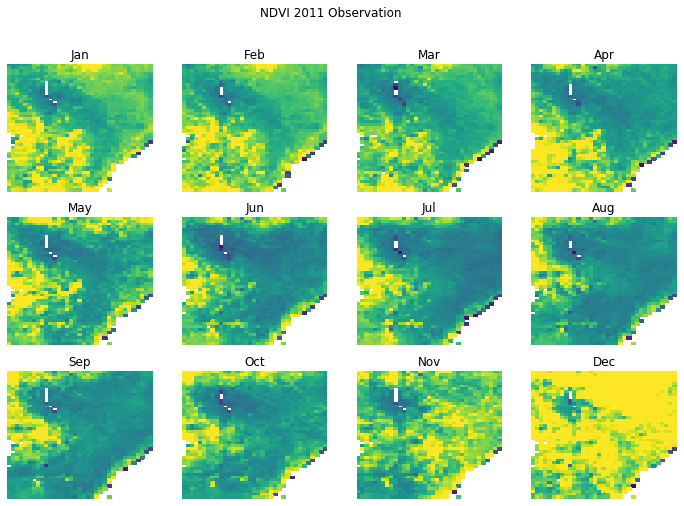

In [374]:
fig, ax = plot_annual_ndvi_maps(
    y_test.sel(time='2011'), variable='ndvi',
    **dict(add_colorbar=False, vmax=0.3, vmin=-0.1)
)

fig.suptitle('NDVI 2011 Observation');

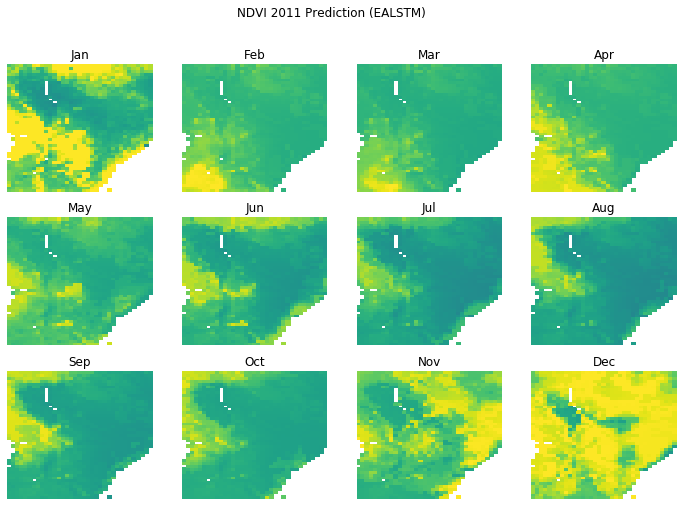

In [377]:
fig, ax = plot_annual_ndvi_maps(
    ealstm_pred.sel(time='2011').to_dataset(name='ndvi'), variable='ndvi',
    **dict(add_colorbar=False, vmax=0.3, vmin=-0.1)
)

fig.suptitle('NDVI 2011 Prediction (EALSTM)');

# Calculate VCI

In [89]:
def calculate_vci(ds: xr.Dataset) -> xr.Dataset:
    ndvi_max = ds.max(dim='time')
    ndvi_min = ds.min(dim='time')
    vci_ds = ((ds - ndvi_min) / (ndvi_max - ndvi_min)) * 100
    return vci_ds, ndvi_min, ndvi_max

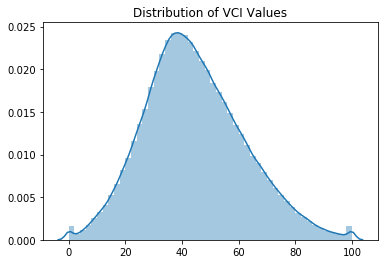

In [90]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
# ds = ds.drop('month')
ndvi_max = ds.max(dim='time')
ndvi_min = ds.min(dim='time')

vci_ds = ((ds - ndvi_min) / (ndvi_max - ndvi_min)) * 100
sns.distplot(drop_nans_and_flatten(vci_ds.ndvi));
ax = plt.gca()

ax.set_title('Distribution of VCI Values');

In [91]:
vci_train = vci_ds.sel(time=slice('1982', '2010')).rename({'ndvi': 'vci'})
vci_test = vci_ds.sel(time=slice('2011', '2019')).rename({'ndvi': 'vci'})

vci_bline = ((bline_pred - ndvi_min) / (ndvi_max - ndvi_min)) * 100
vci_lr = ((lr_pred - ndvi_min) / (ndvi_max - ndvi_min)) * 100
vci_ln = ((ln_pred - ndvi_min) / (ndvi_max - ndvi_min)) * 100
vci_rnn = ((rnn_pred - ndvi_min) / (ndvi_max - ndvi_min)) * 100
vci_ealstm = ((ealstm_pred - ndvi_min) / (ndvi_max - ndvi_min)) * 100

(0, 100)

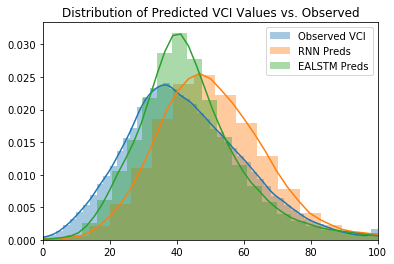

In [441]:
fig, ax = plt.subplots()

sns.distplot(drop_nans_and_flatten(vci_test.vci), ax=ax, label='Observed VCI');
# sns.distplot(drop_nans_and_flatten(vci_lr.ndvi), ax=ax, label='LR Preds');
# sns.distplot(drop_nans_and_flatten(vci_ln.ndvi), ax=ax, label='LN Preds');
sns.distplot(drop_nans_and_flatten(vci_rnn.ndvi), ax=ax, label='RNN Preds');
sns.distplot(drop_nans_and_flatten(vci_ealstm.ndvi), ax=ax, label='EALSTM Preds');

plt.legend()
ax.set_title('Distribution of Predicted VCI Values vs. Observed');
ax.set_xlim([0, 100])

### VCI Comparisons over time

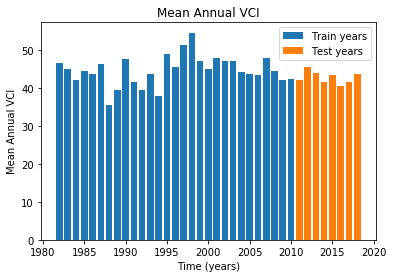

In [110]:
annual_vals = vci_train.groupby('time.year').mean(dim=['time', 'lat', 'lon']).vci.values
years = np.unique(vci_train['time.year'].values)

annual_vals_test = vci_test.groupby('time.year').mean(dim=['time', 'lat', 'lon']).vci.values
years_test = np.unique(vci_test['time.year'].values)

fig, ax = plt.subplots()
ax.bar(height=annual_vals, x=years, label='Train years')
ax.bar(height=annual_vals_test, x=years_test, label='Test years')

plt.legend()
plt.title('Mean Annual VCI')
ax.set_ylabel('Mean Annual VCI')
ax.set_xlabel('Time (years)');

### Exploration of input features

In [111]:
X_train

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 352)
Coordinates:
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2010-11-30
Data variables:
    p84.162  (time, lat, lon) float64 1.777e-06 -7.107e-06 ... 4.323e-05
    pev      (time, lat, lon) float64 -0.005703 -0.006207 ... -2.328e-09
    sp       (time, lat, lon) float64 9.608e+04 9.62e+04 ... 1.011e+05 1.011e+05
    t2m      (time, lat, lon) float64 299.7 301.1 300.6 ... 300.2 300.1 300.2
    tp       (time, lat, lon) float64 0.004603 0.003517 ... 0.001023 0.0009183
    VCI      (time, lat, lon) float64 55.92 77.74 56.97 57.24 ... nan nan nan
    precip   (time, lat, lon) float64 195.3 165.2 140.8 152.1 ... nan nan nan
    ndvi     (time, lat, lon) float64 0.3713 0.4089 0.3843 ... nan nan nan

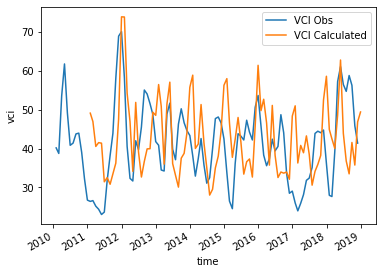

In [136]:
fig, ax = plt.subplots()

X_test.VCI.mean(dim=['lat', 'lon']).plot(ax=ax, label='VCI Obs');
vci_test.vci.mean(dim=['lat', 'lon']).plot(ax=ax, label='VCI Calculated');
# (y_test.ndvi * 245).mean(dim=['lat', 'lon']).plot(ax=ax, label='NDVI');
plt.legend()

In [148]:
X_ds = xr.merge([X_train, X_test]).sortby('time')
X_ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 448)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2018-11-30
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
Data variables:
    p84.162  (time, lat, lon) float64 1.777e-06 -7.107e-06 ... 2.575e-05
    pev      (time, lat, lon) float64 -0.005703 -0.006207 ... -2.328e-09
    sp       (time, lat, lon) float64 9.608e+04 9.62e+04 ... 1.012e+05 1.012e+05
    t2m      (time, lat, lon) float64 299.7 301.1 300.6 ... 300.2 300.2 300.2
    tp       (time, lat, lon) float64 0.004603 0.003517 ... 0.001626 0.001602
    VCI      (time, lat, lon) float64 55.92 77.74 56.97 57.24 ... nan nan nan
    precip   (time, lat, lon) float64 195.3 165.2 140.8 152.1 ... nan nan nan
    ndvi     (time, lat, lon) float64 0.3713 0.4089 0.3843 ... nan nan nan

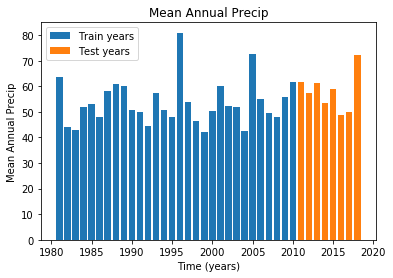

In [156]:
annual_vals = X_ds.sel(time=slice('1982', '2011')).precip.groupby('time.year').mean(dim=['time', 'lat', 'lon']).values
years = np.unique(X_train.precip['time.year'].values) 

annual_vals_test = X_ds.sel(time=slice('2011', '2019')).precip.groupby('time.year').mean(dim=['time', 'lat', 'lon']).values
years_test = np.unique(X_ds.sel(time=slice('2011', '2019')).time.dt.year)

fig, ax = plt.subplots()
ax.bar(height=annual_vals, x=years, label='Train years')
ax.bar(height=annual_vals_test, x=years_test, label='Test years')

plt.legend()
plt.title('Mean Annual Precip')
ax.set_ylabel('Mean Annual Precip')
ax.set_xlabel('Time (years)');

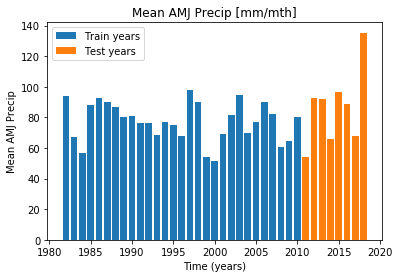

In [160]:
def is_amj(month):
    return (month >= 4) & (month <= 6)

annual_vals = (
    X_ds
    .sel(time=is_amj(X_ds['time.month']))
    .sel(time=slice('1982', '2011'))
    .precip.groupby('time.year').mean(dim=['time', 'lat', 'lon']).values
)
years = np.unique(X_ds.sel(time=slice('1982', '2011')).time.dt.year)

annual_vals_test = (
    X_ds
    .sel(time=is_amj(X_ds['time.month']))
    .sel(time=slice('2011', '2019'))
    .precip.groupby('time.year').mean(dim=['time', 'lat', 'lon']).values
)
years_test = np.unique(X_ds.sel(time=slice('2011', '2019')).time.dt.year)

fig, ax = plt.subplots()
ax.bar(height=annual_vals, x=years, label='Train years')
ax.bar(height=annual_vals_test, x=years_test, label='Test years')

plt.legend()
plt.title('Mean AMJ Precip [mm/mth]')
ax.set_ylabel('Mean AMJ Precip')
ax.set_xlabel('Time (years)');

# Model Performance Comparisons

In [86]:
from src.analysis import spatial_rmse, spatial_r2
%autoreload 2

In [92]:
ealstm_rmse = spatial_rmse(
    y_test.ndvi.transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)
ealstm_rmse_vci = spatial_rmse(
    vci_test.vci.transpose("time", "lat", "lon"), 
    vci_ealstm.ndvi.transpose("time", "lat", "lon")
)

# --------
rnn_rmse = spatial_rmse(
    y_test.ndvi.transpose("time", "lat", "lon"), 
    rnn_pred.transpose("time", "lat", "lon")
)
rnn_rmse_vci = spatial_rmse(
    vci_test.vci.transpose("time", "lat", "lon"), 
    vci_rnn.ndvi.transpose("time", "lat", "lon")
)

# --------
ln_rmse = spatial_rmse(
    y_test.ndvi.transpose("time", "lat", "lon"), 
    ln_pred.transpose("time", "lat", "lon")
)
ln_rmse_vci = spatial_rmse(
    vci_test.vci.transpose("time", "lat", "lon"), 
    vci_ln.ndvi.transpose("time", "lat", "lon")
)

# --------
bline_rmse = spatial_rmse(
    y_test.ndvi.transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)
bline_rmse_vci = spatial_rmse(
    vci_test.vci.transpose("time", "lat", "lon"), 
    vci_bline.ndvi.transpose("time", "lat", "lon")
)

# --------
lr_rmse = spatial_rmse(
    y_test.ndvi.transpose("time", "lat", "lon"), 
    lr_pred.transpose("time", "lat", "lon")
)
lr_rmse_vci = spatial_rmse(
    vci_test.vci.transpose("time", "lat", "lon"), 
    vci_lr.ndvi.transpose("time", "lat", "lon")
)

Text(0.5, 0, 'RMSE')

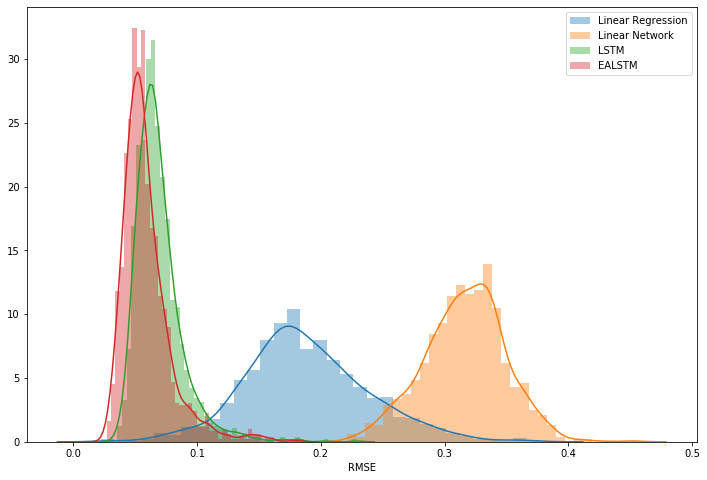

In [195]:
fig, ax = plt.subplots(figsize=(12, 8))
# sns.distplot(drop_nans_and_flatten(bline_rmse), ax=ax, label='Basline')
sns.distplot(drop_nans_and_flatten(lr_rmse), ax=ax, label='Linear Regression')
sns.distplot(drop_nans_and_flatten(ln_rmse), ax=ax, label='Linear Network')
sns.distplot(drop_nans_and_flatten(rnn_rmse), ax=ax, label='LSTM')
sns.distplot(drop_nans_and_flatten(ealstm_rmse), ax=ax, label='EALSTM')

plt.legend()
ax.set_xlabel('RMSE')
# ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

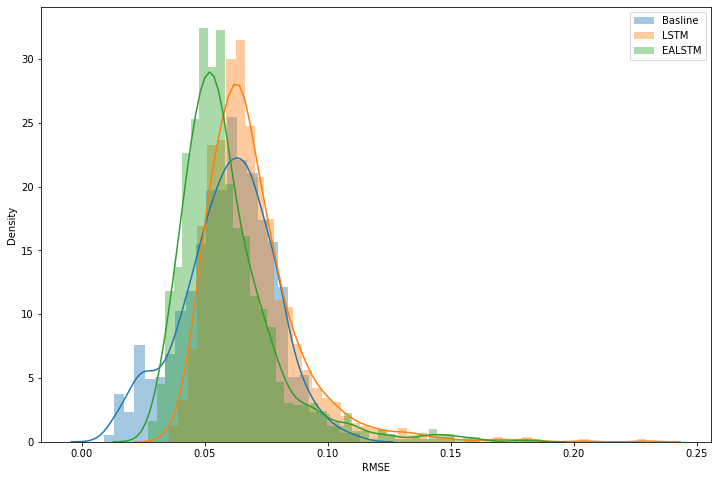

In [209]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(bline_rmse), ax=ax, label='Basline')
# sns.distplot(drop_nans_and_flatten(lr_rmse), ax=ax, label='Linear Regression')
# sns.distplot(drop_nans_and_flatten(ln_rmse), ax=ax, label='Linear Network')
sns.distplot(drop_nans_and_flatten(rnn_rmse), ax=ax, label='LSTM')
sns.distplot(drop_nans_and_flatten(ealstm_rmse), ax=ax, label='EALSTM')

plt.legend()
ax.set_xlabel('RMSE')
ax.set_ylabel('Density')

Can we calculate the cumulative probability of 

In [489]:
# bline_rmse.mean().values

array(0.05962341)

In [493]:
((bline_rmse.mean().values - ealstm_rmse.mean().values) / bline_rmse.mean().values)*100

0.6096485848525987

# Regional Analysis

In [214]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)

r = RegionGeoPlotter(data_dir)

# for the training data
ds

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'linear_network', 'linear_regression', 'previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed


<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 437)
Coordinates:
  * time     (time) datetime64[ns] 1982-08-31 1982-09-30 ... 2018-12-31
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    ndvi     (time, lat, lon) float64 0.1727 0.1627 0.1505 ... 0.2684 0.2417
    month    (time) float64 8.0 9.0 10.0 11.0 12.0 1.0 ... nan nan nan nan nan

In [215]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

In [216]:
# da.where(region_da == 0).mean(dim=['lat', 'lon']).values

In [217]:
da = ds.ndvi
region_names = []
true_mean_value = []
datetimes = [pd.to_datetime(t) for t in da.time.values]

region_data_dict = {}
region_data_dict['datetime'] = datetimes

for valid_region_id in valid_region_ids:
    region_vals = da.where(region_da == valid_region_id).mean(dim=['lat', 'lon']).values
    region_data_dict[region_lookup[valid_region_id]] = region_vals

all_df = pd.DataFrame(region_data_dict)
all_df.head()

datetime   NAIROBI    KIAMBU  KIRINYAGA   MURANGA  NYANDARUA     NYERI  \
0 1982-08-31  0.106847  0.109803   0.077426  0.119330   0.122552  0.142941   
1 1982-09-30  0.160979  0.179884   0.144922  0.202528   0.185252  0.162684   
2 1982-10-31  0.184252  0.190499   0.174103  0.264948   0.172744  0.155475   
3 1982-11-30  0.197070  0.189345   0.124438  0.157100   0.100008  0.109020   
4 1982-12-31  0.309432  0.251125   0.228095  0.260907   0.235159  0.238382   

      THIKA   MARAGUA    KILIFI      ...        WEST POKOT     BURET  \
0  0.100848  0.110245  0.209104      ...          0.209142  0.131525   
1  0.206362  0.249235  0.224078      ...          0.246475  0.173438   
2  0.233001  0.204864  0.241763      ...          0.171087  0.166880   
3  0.217815  0.213676  0.253085      ...          0.178346  0.126160   
4  0.299881  0.318232  0.261185      ...          0.278300  0.311264   

    BUNGOMA     BUSIA  MT ELGON  KAKAMEGA    LUGARI      TESO    VIHIGA  \
0  0.195766  0.225852  0.122330  0.248017  0.228273  0.145130  0.279687   
1  0.198000  0.346002  0.146670  0.288286  0.235778  0.214048  0.304481   
2  0.134696  0.227408  0.128625  0.198728  0.191082  0.132222  0.173259   
3  0.182360  0.186580  0.119144  0.171643  0.171992  0.148158  0.189196   
4  0.278745  0.366672  0.204559  0.320378  0.262334  0.263782  0.306617   

   BUTERE/MUMIAS  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 70 columns]

In [15]:
from src.analysis import AdministrativeRegionAnalysis

In [16]:
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)
analyzer.analyze()

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'linear_network', 'linear_regression', 'previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for linear_network-district_l2_kenya **
** Written linear_network csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/linear_network/linear_network_district_l2_kenya.csv **

** Analyzing for linear_regression-district_l2_kenya **
** Written linear_regression csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/linear_regression/linear_regression_district_l2_kenya.csv **

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analy

In [17]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [18]:
# join true/preds into a GeoDataFrame
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
# all_gdf['predicted_mean_value'] = all_gdf.predicted_mean_value * 10
# all_gdf['true_mean_value'] = all_gdf.true_mean_value * 10
all_gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


admin_level_name              model   datetime region_name  \
0  district_l2_kenya             ealstm 2011-01-31     NAIROBI   
1  district_l2_kenya     linear_network 2011-01-31     NAIROBI   
2  district_l2_kenya                rnn 2011-01-31     NAIROBI   
3  district_l2_kenya     previous_month 2011-01-31     NAIROBI   
4  district_l2_kenya  linear_regression 2011-01-31     NAIROBI   

   predicted_mean_value  true_mean_value DISTNAME  \
0          4.102199e-01         0.362545  NAIROBI   
1         -1.991590e+00         0.362545  NAIROBI   
2          3.886054e-01         0.362545  NAIROBI   
3          3.816484e-01         0.362545  NAIROBI   
4         -1.037418e-07         0.362545  NAIROBI   

                                            geometry  
0  POLYGON ((36.90575473150634 -1.159051062893981...  
1  POLYGON ((36.90575473150634 -1.159051062893981...  
2  POLYGON ((36.90575473150634 -1.159051062893981...  
3  POLYGON ((36.90575473150634 -1.159051062893981...  
4  POLYGON ((36.90575473150634 -1.159051062893981...

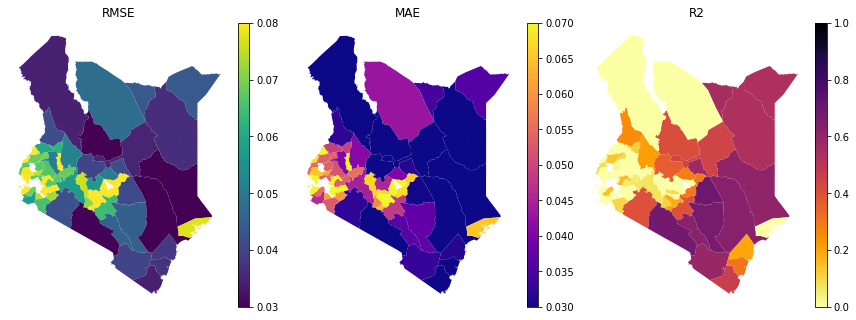

In [207]:
%autoreload 2
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'ealstm').dropna(),
    **dict(rmse_vmax=0.08, mae_vmax=0.07, mae_vmin=0.03, rmse_vmin=0.03)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

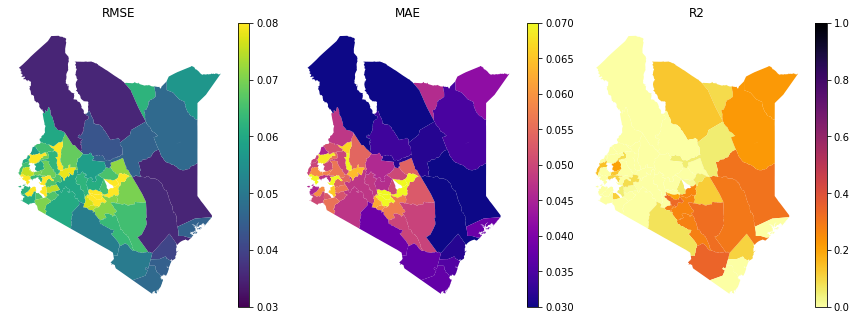

In [208]:
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'previous_month').dropna(),
    **dict(rmse_vmax=0.08, mae_vmax=0.07, mae_vmin=0.03, rmse_vmin=0.03)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [39]:
kwargs = {}
ll = kwargs['rmse_vmin'] if 'rmse_vmin' in kwargs else None
ll

### Region timeseries

In [26]:
np.unique(all_gdf.region_name)

array(['BARINGO', 'BOMET', 'BONDO', 'BUNGOMA', 'BURET', 'BUSIA',
       'BUTERE/MUMIAS', 'CENTRAL KISII', 'EMBU', 'GARISSA', 'GUCHA',
       'HOMA BAY', 'ISIOLO', 'KAJIADO', 'KAKAMEGA', 'KEIYO', 'KERICHO',
       'KIAMBU', 'KILIFI', 'KIRINYAGA', 'KISUMU', 'KITUI', 'KOIBATEK',
       'KURIA', 'KWALE', 'LAIKIPIA', 'LAMU', 'LUGARI', 'MACHAKOS',
       'MAKUENI', 'MALINDI', 'MANDERA', 'MARAGUA', 'MARAKWET', 'MARSABIT',
       'MBEERE', 'MERU CENTRAL', 'MERU NORTH', 'MERU SOUTH', 'MIGORI',
       'MOMBASA', 'MOYALE', 'MT ELGON', 'MURANGA', 'MWINGI', 'NAIROBI',
       'NAKURU', 'NANDI', 'NAROK', 'NYAMIRA', 'NYANDARUA', 'NYANDO',
       'NYERI', 'RACHUONYO', 'SAMBURU', 'SIAYA', 'SUBA', 'TAITA TAVETA',
       'TANA RIVER', 'TESO', 'THARAKA', 'THIKA', 'TRANS MARA',
       'TRANS NZOIA', 'TURKANA', 'UASIN GISHU', 'VIHIGA', 'WAJIR',
       'WEST POKOT'], dtype=object)

In [226]:
region = 'MARSABIT'

def plot_region_time_series(region: str, ax=None, lstm: bool = False, ealstm: bool = True):
    times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].datetime 
    obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].true_mean_value
    rnn_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].predicted_mean_value
    ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value
    lr_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_regression')].predicted_mean_value
    ln_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_network')].predicted_mean_value
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    df_dict = {'obs' : obs_ts.values}
    
    if lstm:
        df_dict['lstm'] = rnn_ts.values,
    if ealstm:
        df_dict['ealstm'] = ealstm_ts.values

    pd.DataFrame(df_dict, index=times).iloc[1:].plot(ax=ax)

    ax.set_ylim(0, 0.5)
    ax.set_title(f'{region} Predicted vs. Modelled');
    
    return fig, ax


def plot_region_seasonality(region, ax=None):
    ts = (
        all_df
        .loc[:, ['datetime', region]
        ].set_index('datetime')
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean NDVI');
    
    return fig, ax


def plot_region_vs_observed_seasonality(region, model, ax=None):
    ts = (
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region), 
            ['datetime', 'true_mean_value', 'predicted_mean_value']
        ].set_index('datetime')
    ).rename(
        columns={'true_mean_value': 'Observed', 'predicted_mean_value': f'Predicted ({model.upper()})'}
    )
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle for {region} District')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean NDVI');

    return fig, ax

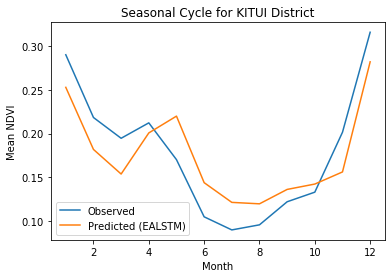

In [211]:
plot_region_vs_observed_seasonality(region='KITUI', model='ealstm');

### Northern Counties

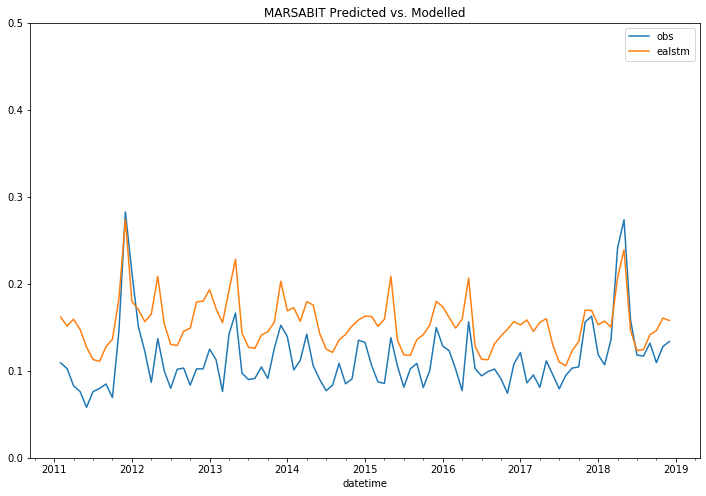

In [227]:
# plot_region_time_series(region='TURKANA');
fig, ax = plt.subplots(figsize=(12, 8))
plot_region_time_series(region='MARSABIT', ax=ax);
# plot_region_time_series(region='WAJIR');
# plot_region_time_series(region='MANDERA');

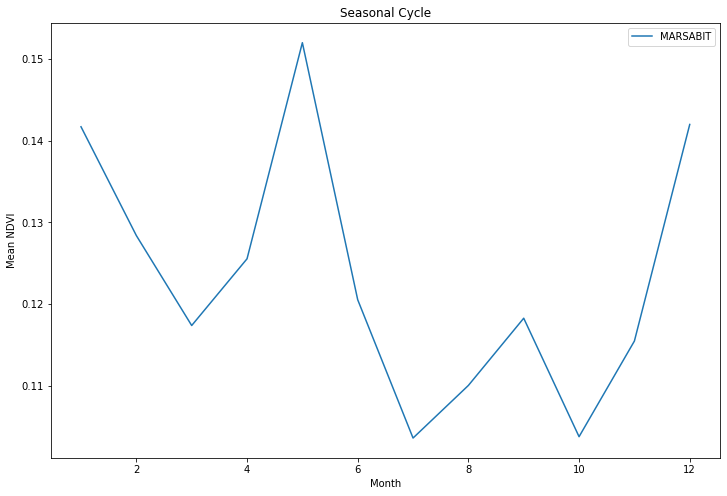

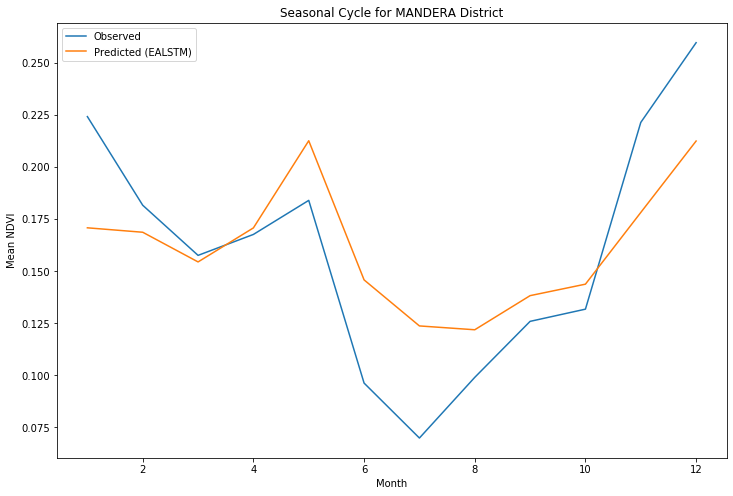

In [223]:
fig, ax = plt.subplots(figsize=(12, 8))
# plot_region_seasonality(region='TURKANA', ax=ax);
plot_region_seasonality(region='MARSABIT', ax =ax);
# plot_region_seasonality(region='WAJIR', ax =ax);
# plot_region_seasonality(region='MANDERA', ax =ax);

fig, ax = plt.subplots(figsize=(12, 8))
plot_region_vs_observed_seasonality(region='MANDERA', model='ealstm', ax=ax);


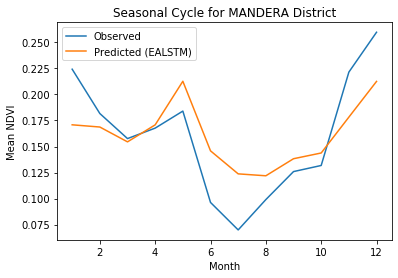

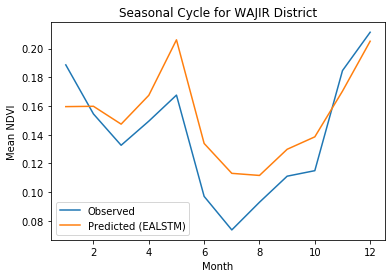

In [46]:
plot_region_vs_observed_seasonality(region='MANDERA', model='ealstm');
plot_region_vs_observed_seasonality(region='WAJIR', model='ealstm');

### Southern Counties

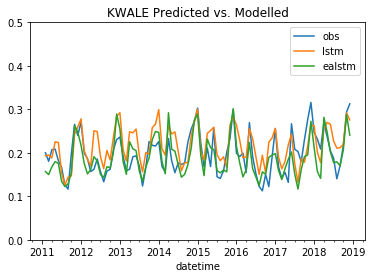

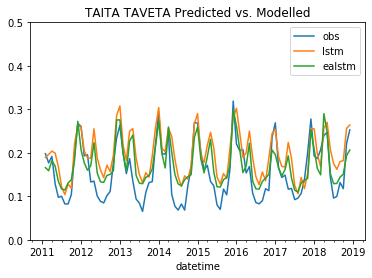

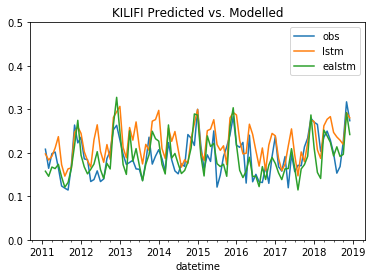

In [40]:
plot_region_time_series(region='KWALE');
plot_region_time_series(region='TAITA TAVETA');
plot_region_time_series(region='KILIFI');

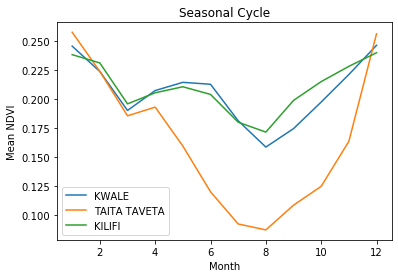

In [41]:
fig, ax = plt.subplots()
plot_region_seasonality(region='KWALE', ax=ax);
plot_region_seasonality(region='TAITA TAVETA', ax=ax);
plot_region_seasonality(region='KILIFI', ax=ax);

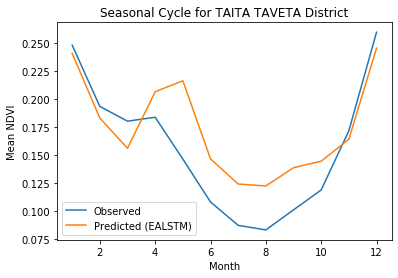

In [101]:
plot_region_vs_observed_seasonality(region='TAITA TAVETA', model='ealstm');

### Eastern Counties

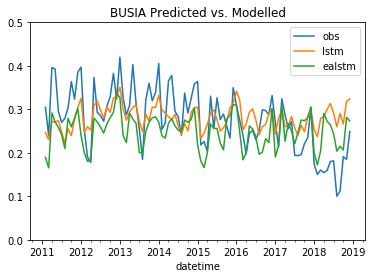

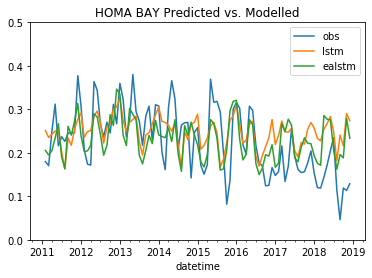

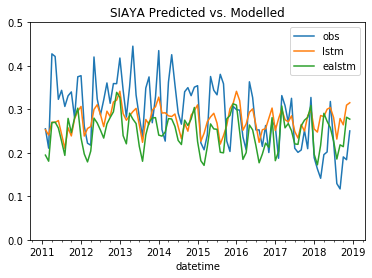

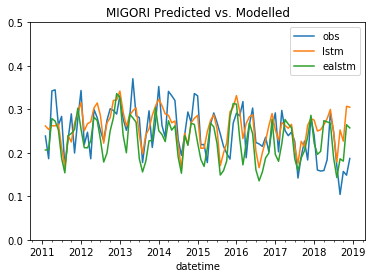

In [649]:
plot_region_time_series(region='BUSIA');
plot_region_time_series(region='HOMA BAY');
plot_region_time_series(region='SIAYA');
plot_region_time_series(region='MIGORI');

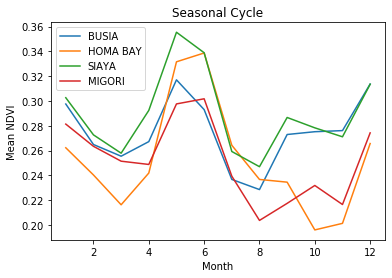

In [42]:
fig, ax = plt.subplots()
plot_region_seasonality(ax=ax, region='BUSIA')
plot_region_seasonality(ax=ax, region='HOMA BAY')
plot_region_seasonality(ax=ax, region='SIAYA')
plot_region_seasonality(ax=ax, region='MIGORI');

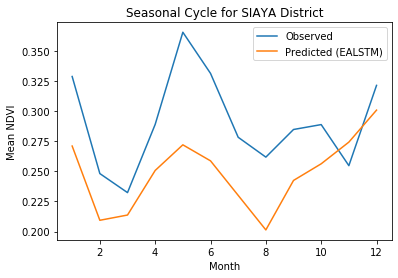

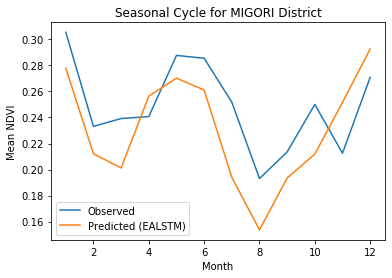

In [102]:
plot_region_vs_observed_seasonality(region='SIAYA', model='ealstm');
plot_region_vs_observed_seasonality(region='MIGORI', model='ealstm');

### Rift Valley 

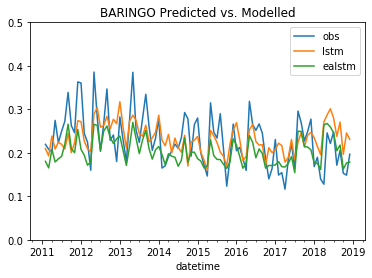

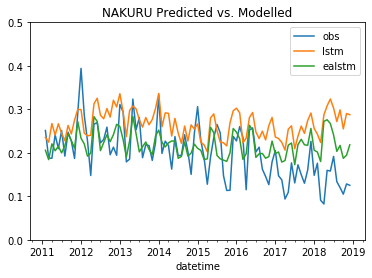

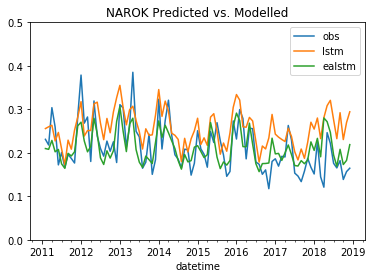

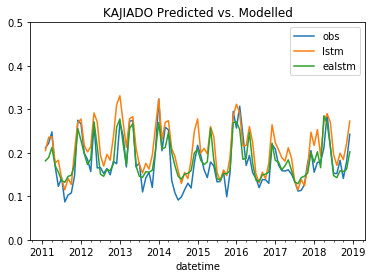

In [43]:
plot_region_time_series(region='BARINGO');
plot_region_time_series(region='NAKURU');
plot_region_time_series(region='NAROK');
plot_region_time_series(region='KAJIADO');

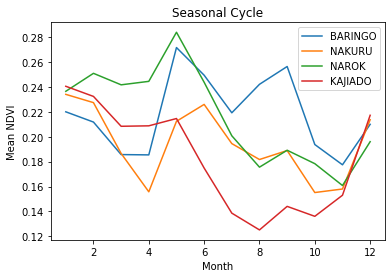

In [44]:
fig, ax = plt.subplots()
plot_region_seasonality(ax=ax, region='BARINGO');
plot_region_seasonality(ax=ax, region='NAKURU');
plot_region_seasonality(ax=ax, region='NAROK');
plot_region_seasonality(ax=ax, region='KAJIADO');

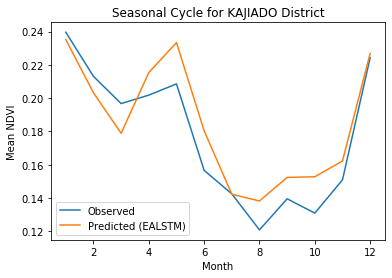

In [103]:
plot_region_vs_observed_seasonality(region='KAJIADO', model='ealstm');

### Central Highlands, High Potential Zone

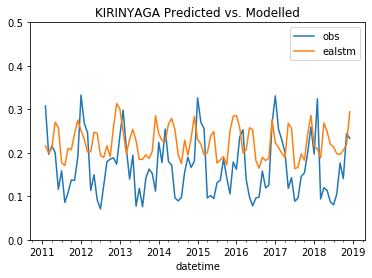

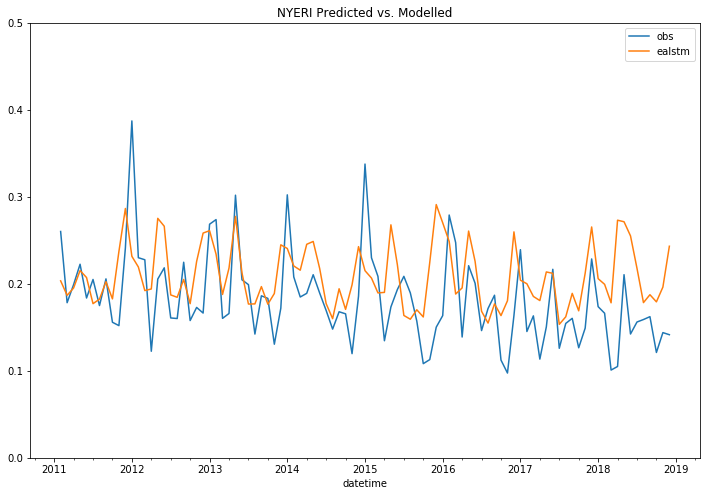

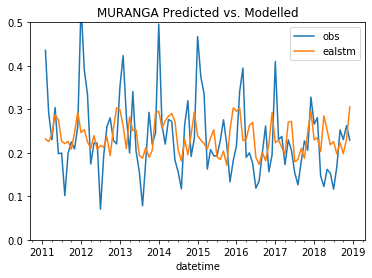

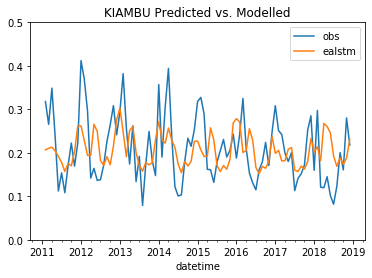

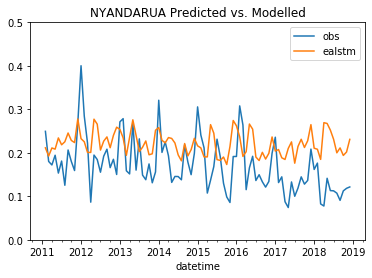

In [254]:
plot_region_time_series(region='KIRINYAGA');
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='NYERI', ax=ax);
plot_region_time_series(region='MURANGA');
plot_region_time_series(region='KIAMBU');
plot_region_time_series(region='NYANDARUA');

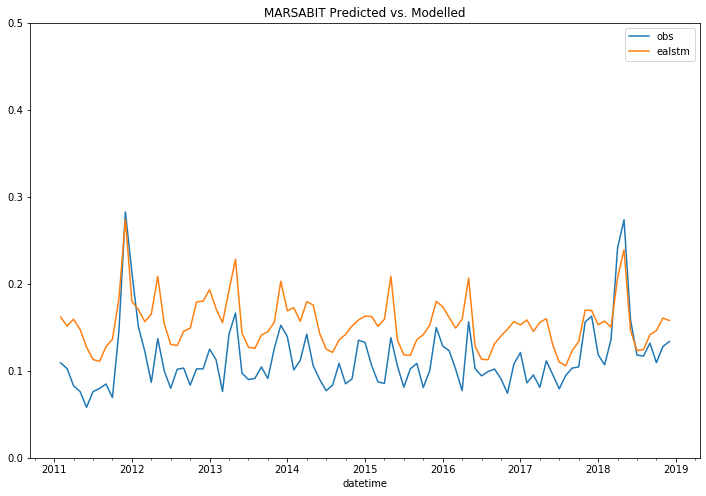

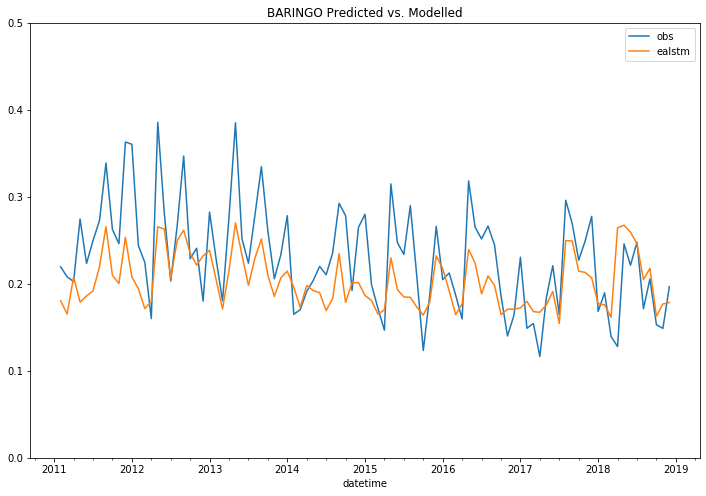

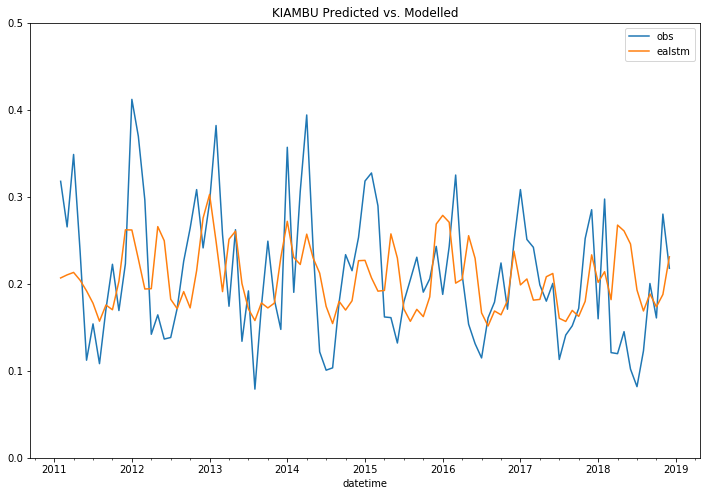

In [267]:
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='MARSABIT', ax=ax);
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='BARINGO', ax=ax);
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='KIAMBU', ax=ax);


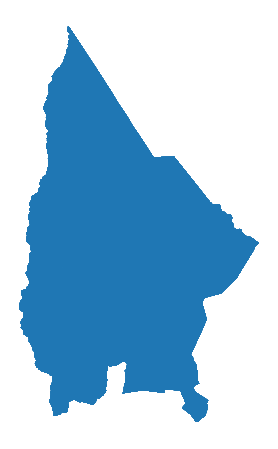

In [231]:
# times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].datetime 
# obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].true_mean_value
# ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value
# pers_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'previous_month')].predicted_mean_value

KIAMBU EALSTM RMSE: 0.088
KIAMBU Persistence RMSE: 0.086
MARSABIT EALSTM RMSE: 0.059
MARSABIT Persistence RMSE: 0.038
BARINGO EALSTM RMSE: 0.074
BARINGO Persistence RMSE: 0.078


(0, 0.09)

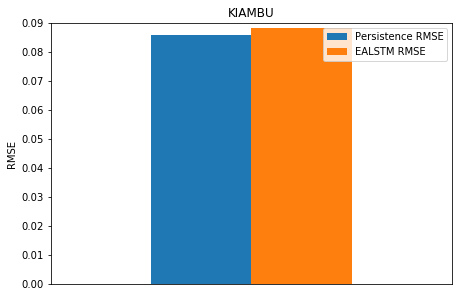

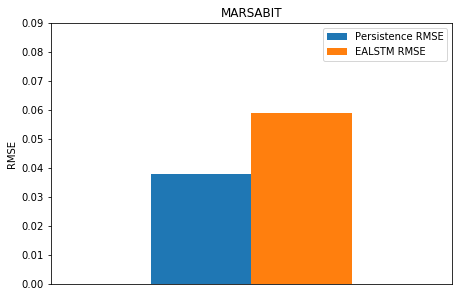

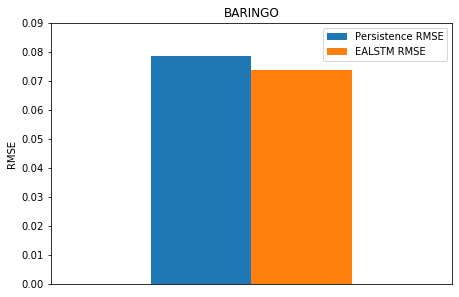

In [282]:
inv_lookup = {v: k for k, v in region_lookup.items()}

region = 'KIAMBU'
model_error = ealstm_rmse.where(region_da == inv_lookup[region]).mean().values
bline_error = bline_rmse.where(region_da == inv_lookup[region]).mean().values
print(f"{region} EALSTM RMSE: {model_error:.3f}")
print(f"{region} Persistence RMSE: {bline_error:.3f}")

scale=0.6
fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
pd.DataFrame({'Persistence RMSE': bline_error, 'EALSTM RMSE': model_error}, index=[0]).plot.bar(ax=ax)
ax.set_ylabel('RMSE')
ax.get_xaxis().set_visible(False)
ax.set_title(region)
ax.set_ylim(0, 0.09)

# bline_rmse

region = 'MARSABIT'

model_error = ealstm_rmse.where(region_da == inv_lookup[region]).mean().values
bline_error = bline_rmse.where(region_da == inv_lookup[region]).mean().values
print(f"{region} EALSTM RMSE: {model_error:.3f}")
print(f"{region} Persistence RMSE: {bline_error:.3f}")

scale=0.6
fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
pd.DataFrame({'Persistence RMSE': bline_error, 'EALSTM RMSE': model_error}, index=[0]).plot.bar(ax=ax)
ax.set_ylabel('RMSE')
ax.get_xaxis().set_visible(False)
ax.set_title(region)
ax.set_ylim(0, 0.09)



region = 'BARINGO'

model_error = ealstm_rmse.where(region_da == inv_lookup[region]).mean().values
bline_error = bline_rmse.where(region_da == inv_lookup[region]).mean().values
print(f"{region} EALSTM RMSE: {model_error:.3f}")
print(f"{region} Persistence RMSE: {bline_error:.3f}")

scale=0.6
fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
pd.DataFrame({'Persistence RMSE': bline_error, 'EALSTM RMSE': model_error}, index=[0]).plot.bar(ax=ax)
ax.set_ylabel('RMSE')
ax.get_xaxis().set_visible(False)
ax.set_title(region)
ax.set_ylim(0, 0.09)


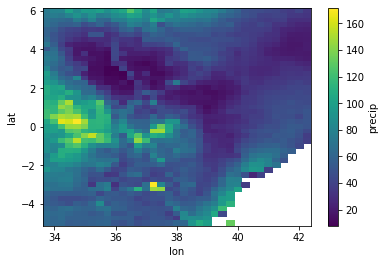

In [260]:
X_ds = xr.merge([X_train, X_test]).sortby('time')
X_ds.mean(dim='time').precip.plot()

In [253]:
all_gdf.loc[(all_gdf.model == 'ealstm') & (all_gdf.model == 'ealstm')]

admin_level_name              model   datetime region_name  \
0      district_l2_kenya             ealstm 2011-01-31     NAIROBI   
1      district_l2_kenya     linear_network 2011-01-31     NAIROBI   
2      district_l2_kenya                rnn 2011-01-31     NAIROBI   
3      district_l2_kenya     previous_month 2011-01-31     NAIROBI   
4      district_l2_kenya  linear_regression 2011-01-31     NAIROBI   
5      district_l2_kenya     previous_month 2011-02-28     NAIROBI   
6      district_l2_kenya  linear_regression 2011-02-28     NAIROBI   
7      district_l2_kenya                rnn 2011-02-28     NAIROBI   
8      district_l2_kenya     linear_network 2011-02-28     NAIROBI   
9      district_l2_kenya             ealstm 2011-02-28     NAIROBI   
10     district_l2_kenya     linear_network 2011-03-31     NAIROBI   
11     district_l2_kenya  linear_regression 2011-03-31     NAIROBI   
12     district_l2_kenya                rnn 2011-03-31     NAIROBI   
13     district_l2_kenya             ealstm 2011-03-31     NAIROBI   
14     district_l2_kenya     previous_month 2011-03-31     NAIROBI   
15     district_l2_kenya     previous_month 2011-04-30     NAIROBI   
16     district_l2_kenya     linear_network 2011-04-30     NAIROBI   
17     district_l2_kenya                rnn 2011-04-30     NAIROBI   
18     district_l2_kenya             ealstm 2011-04-30     NAIROBI   
19     district_l2_kenya  linear_regression 2011-04-30     NAIROBI   
20     district_l2_kenya             ealstm 2011-05-31     NAIROBI   
21     district_l2_kenya                rnn 2011-05-31     NAIROBI   
22     district_l2_kenya  linear_regression 2011-05-31     NAIROBI   
23     district_l2_kenya     previous_month 2011-05-31     NAIROBI   
24     district_l2_kenya     linear_network 2011-05-31     NAIROBI   
25     district_l2_kenya     previous_month 2011-06-30     NAIROBI   
26     district_l2_kenya  linear_regression 2011-06-30     NAIROBI   
27     district_l2_kenya                rnn 2011-06-30     NAIROBI   
28     district_l2_kenya             ealstm 2011-06-30     NAIROBI   
29     district_l2_kenya     linear_network 2011-06-30     NAIROBI   
...                  ...                ...        ...         ...   
33090  district_l2_kenya             ealstm 2018-07-31     NYAMIRA   
33091  district_l2_kenya                rnn 2018-07-31     NYAMIRA   
33092  district_l2_kenya     linear_network 2018-07-31     NYAMIRA   
33093  district_l2_kenya     previous_month 2018-07-31     NYAMIRA   
33094  district_l2_kenya  linear_regression 2018-07-31     NYAMIRA   
33095  district_l2_kenya                rnn 2018-08-31     NYAMIRA   
33096  district_l2_kenya             ealstm 2018-08-31     NYAMIRA   
33097  district_l2_kenya     linear_network 2018-08-31     NYAMIRA   
33098  district_l2_kenya     previous_month 2018-08-31     NYAMIRA   
33099  district_l2_kenya  linear_regression 2018-08-31     NYAMIRA   
33100  district_l2_kenya             ealstm 2018-09-30     NYAMIRA   
33101  district_l2_kenya                rnn 2018-09-30     NYAMIRA   
33102  district_l2_kenya     linear_network 2018-09-30     NYAMIRA   
33103  district_l2_kenya     previous_month 2018-09-30     NYAMIRA   
33104  district_l2_kenya  linear_regression 2018-09-30     NYAMIRA   
33105  district_l2_kenya     previous_month 2018-10-31     NYAMIRA   
33106  district_l2_kenya                rnn 2018-10-31     NYAMIRA   
33107  district_l2_kenya             ealstm 2018-10-31     NYAMIRA   
33108  district_l2_kenya  linear_regression 2018-10-31     NYAMIRA   
33109  district_l2_kenya     linear_network 2018-10-31     NYAMIRA   
33110  district_l2_kenya  linear_regression 2018-11-30     NYAMIRA   
33111  district_l2_kenya     linear_network 2018-11-30     NYAMIRA   
33112  district_l2_kenya             ealstm 2018-11-30     NYAMIRA   
33113  district_l2_kenya                rnn 2018-11-30     NYAMIRA   
33114  district_l2_kenya     previous_month 2018-11-30     NYAMIRA   
33115  district_l2

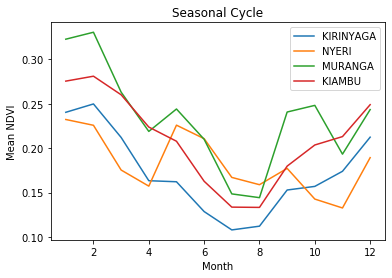

In [46]:
fig, ax = plt.subplots()
plot_region_seasonality(ax=ax, region='KIRINYAGA');
plot_region_seasonality(ax=ax, region='NYERI');
plot_region_seasonality(ax=ax, region='MURANGA');
plot_region_seasonality(ax=ax, region='KIAMBU');

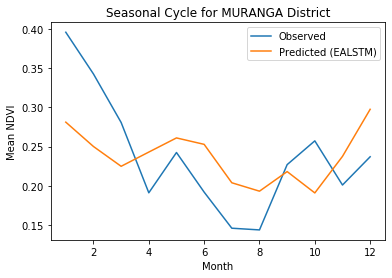

In [104]:
plot_region_vs_observed_seasonality(region='MURANGA', model='ealstm');

### Why is the linear regression so messed up?

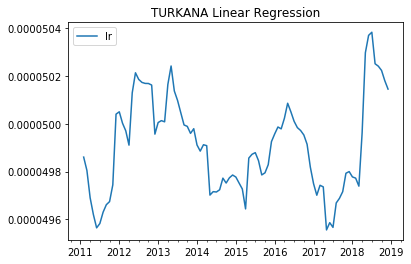

In [64]:
region = 'TURKANA'

lr_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_regression')].predicted_mean_value
times = [pd.to_datetime(t) for t in np.unique(all_gdf.datetime)]

fig, ax = plt.subplots()

pd.DataFrame({
    'lr' : lr_ts.values,
}, index=times).iloc[1:].plot(ax=ax)

ax.set_title(f'{region} Linear Regression');

# Landcover Analysis

In [587]:
from src.analysis import LandcoverRegionAnalysis


In [591]:
l = LandcoverRegionAnalysis(data_dir=data_dir)
# l.analyze()

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'linear_network', 'linear_regression', 'previous_month', 'rnn']
Regions: []
Region Type: landcover
